# Time Series Forecasting Tutorial
## Using Machine Learning to Forecast Energy Consumption

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

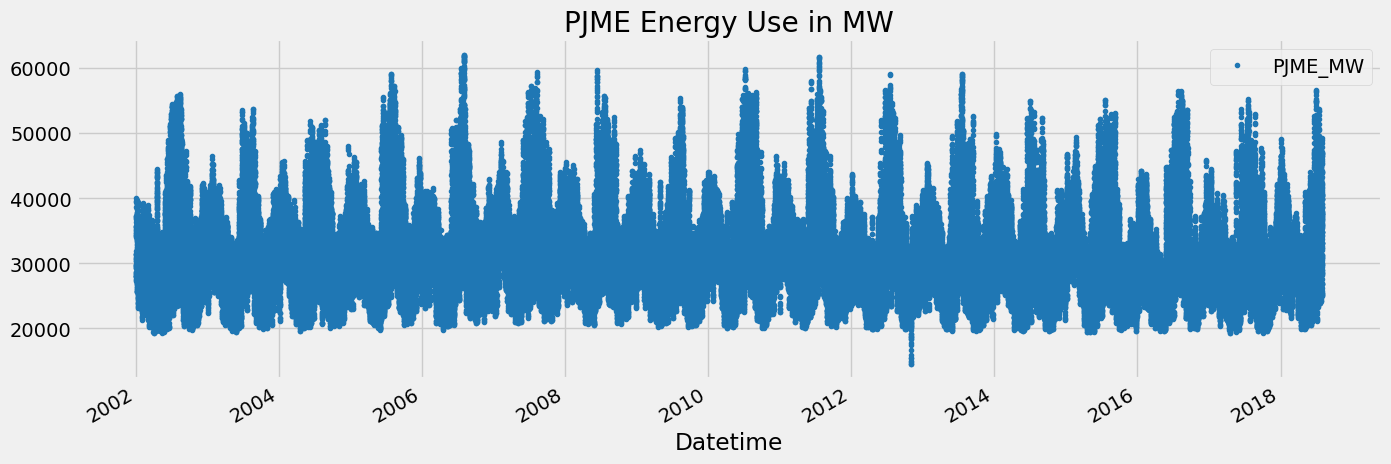

In [3]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

# Train / Test Split

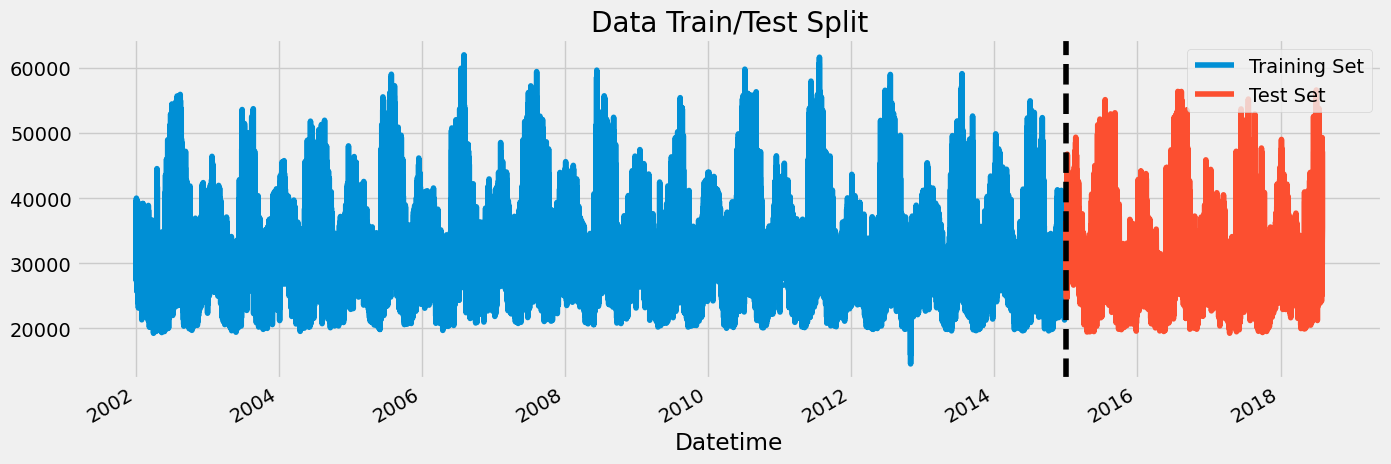

In [4]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

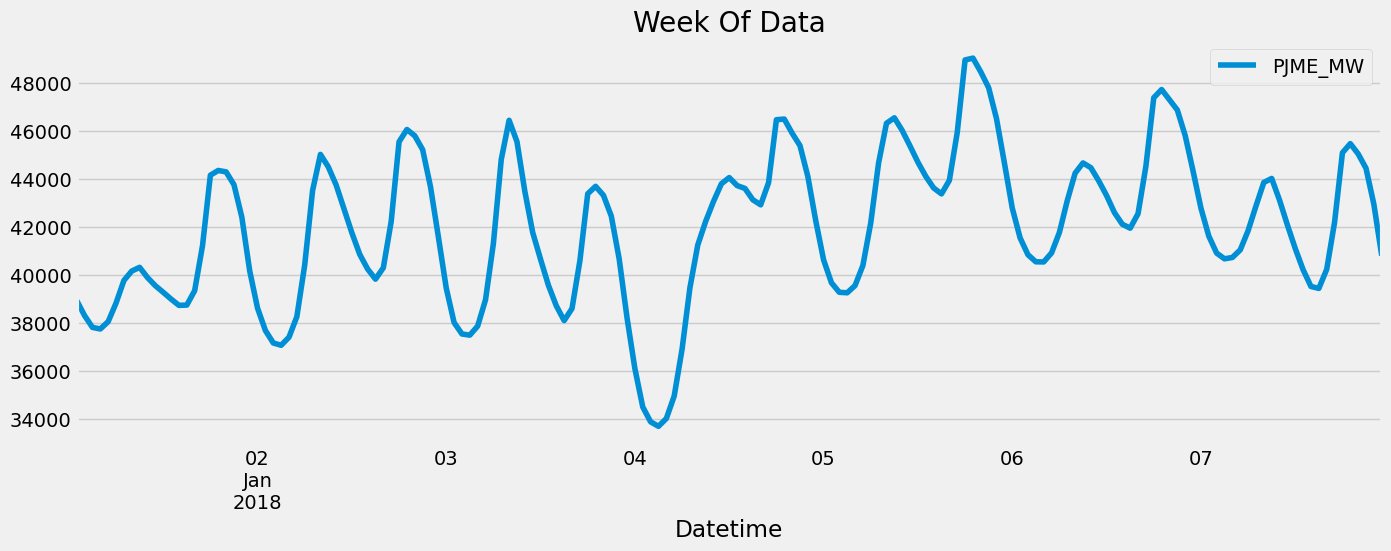

In [5]:
df = df.sort_index()

df.loc[(df.index > '2018-01-01') & (df.index < '2018-01-08')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()


# Feature Creation
https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.dayofweek.html

In [6]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# Visualize our Feature / Target Relationship

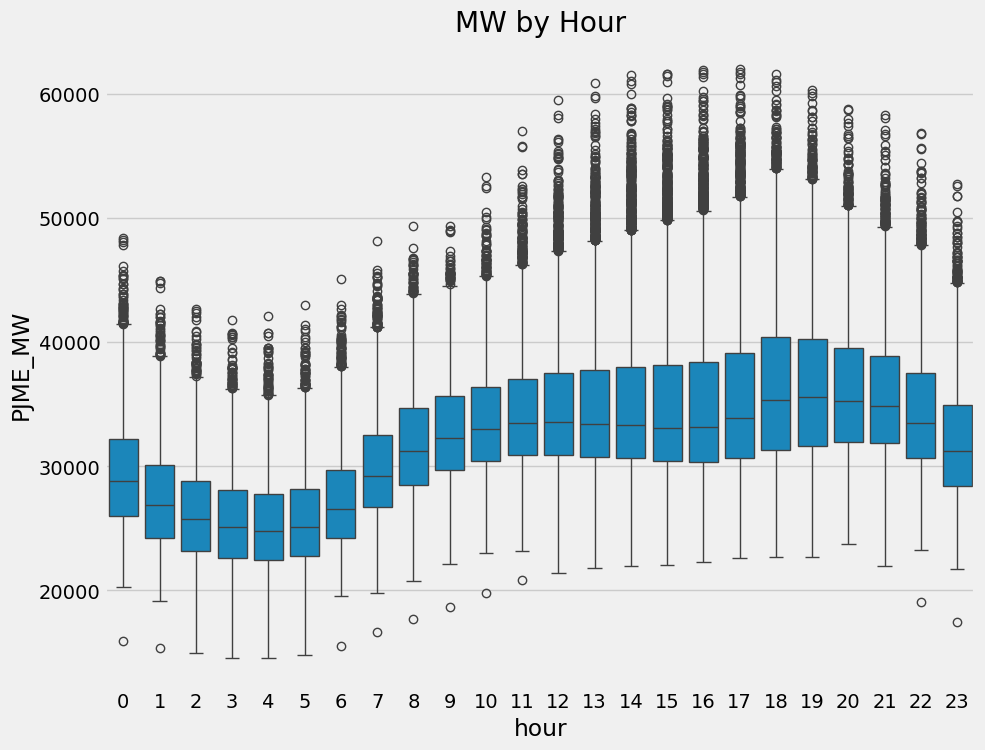

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

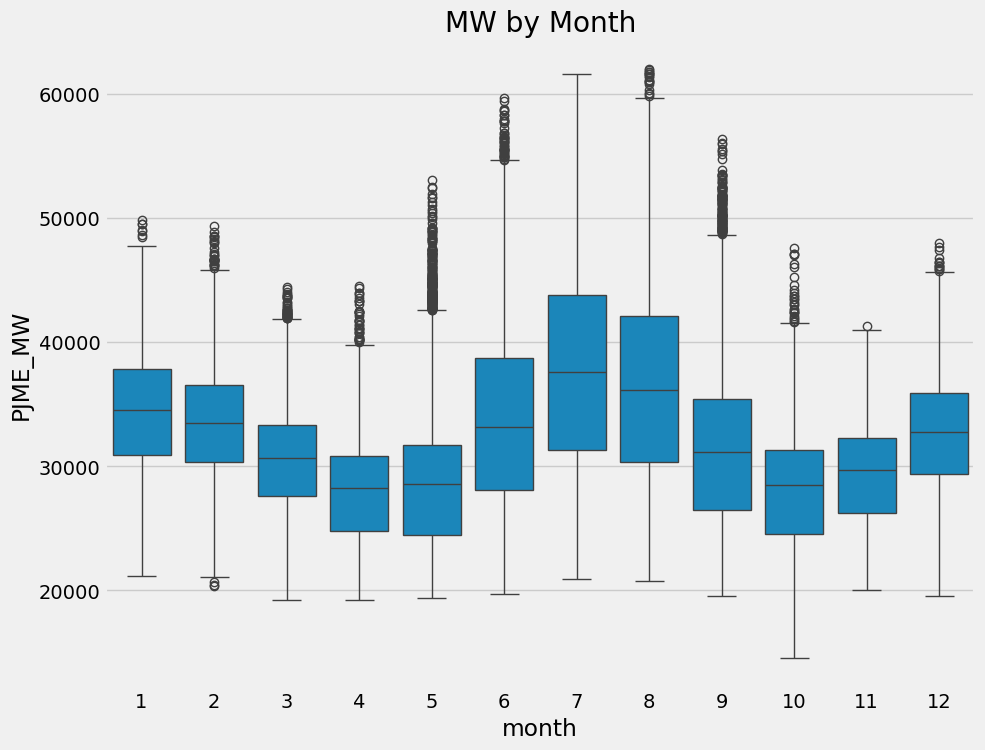

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW')
ax.set_title('MW by Month')
plt.show()

# Create our Model

In [9]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [10]:
reg = xgb.XGBRegressor(n_estimators=1000,
                #       early_stopping_rounds=50,
                #       max_depth=3,
                #       learning_rate=0.01
                      )
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True)

[0]	validation_0-rmse:5179.23300	validation_1-rmse:5359.30943
[1]	validation_0-rmse:4375.01962	validation_1-rmse:4687.00132
[2]	validation_0-rmse:3874.17400	validation_1-rmse:4279.28898
[3]	validation_0-rmse:3572.89245	validation_1-rmse:4082.60841
[4]	validation_0-rmse:3372.17780	validation_1-rmse:3952.54672
[5]	validation_0-rmse:3247.62891	validation_1-rmse:3881.05746
[6]	validation_0-rmse:3162.64310	validation_1-rmse:3856.13245
[7]	validation_0-rmse:3073.82520	validation_1-rmse:3790.13994
[8]	validation_0-rmse:3021.60497	validation_1-rmse:3790.80157
[9]	validation_0-rmse:2967.30458	validation_1-rmse:3762.76936
[10]	validation_0-rmse:2888.42820	validation_1-rmse:3765.37637
[11]	validation_0-rmse:2870.15625	validation_1-rmse:3759.06623
[12]	validation_0-rmse:2813.33663	validation_1-rmse:3779.46019
[13]	validation_0-rmse:2779.04333	validation_1-rmse:3817.51231
[14]	validation_0-rmse:2760.93139	validation_1-rmse:3808.04851
[15]	validation_0-rmse:2739.22479	validation_1-rmse:3798.04910
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

# Feature Importance

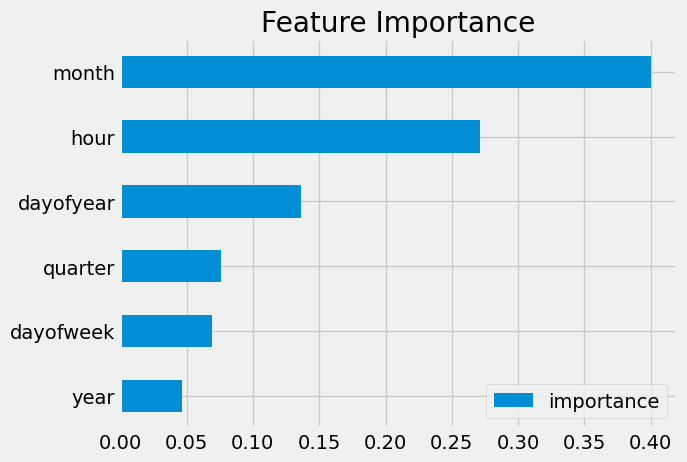

In [11]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

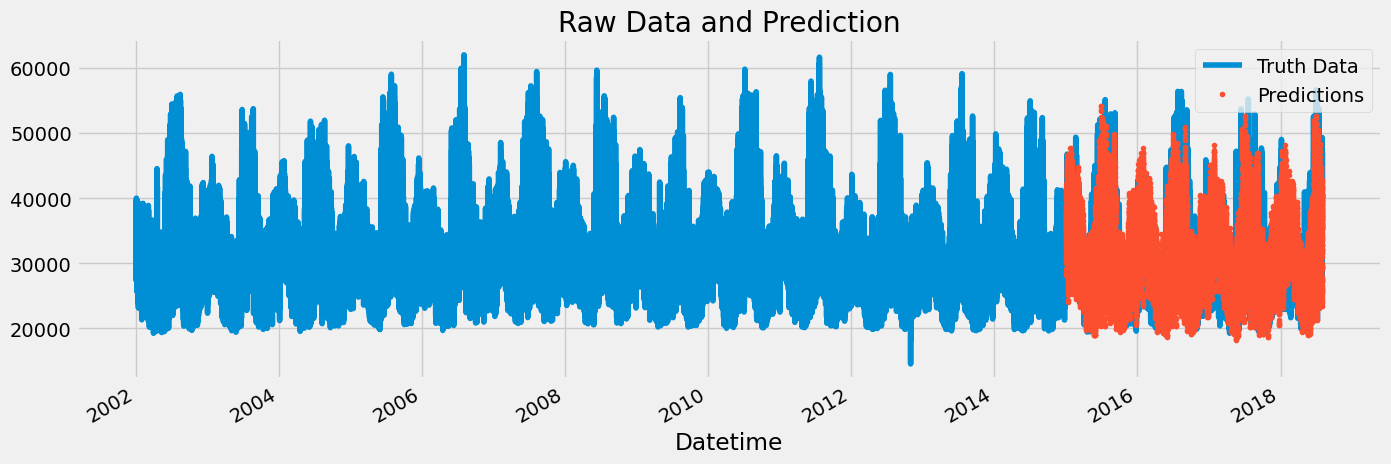

In [12]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

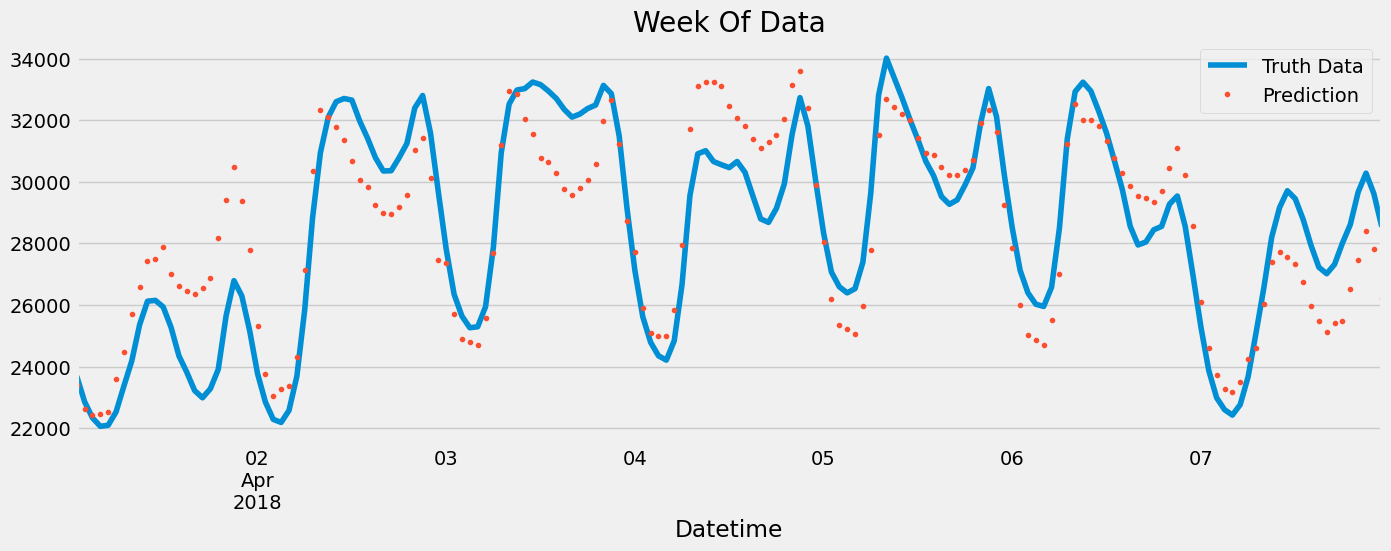

In [13]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [14]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 4499.00


# Calculate Error
- Look at the worst and best predicted days

In [15]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    17811.158040
2016-08-14    16171.342773
2016-08-12    14751.007568
2017-09-02    14289.224609
2017-01-25    13044.634115
2015-02-20    12629.768229
2016-08-11    12523.626628
2017-01-26    12338.819336
2015-07-19    12333.817139
2015-02-21    12291.933350
Name: error, dtype: float64

# Next Step
- More robust cross validation (part 2)
# Your Turn
- Add more features (weather forecast, holidays)

# The Next